In [1]:
from src.paths import OXFORD_DATA_DIR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data is from the 2021 Census. Downloaded from ons.gov.uk/
# From the download page:
#       This dataset provides 2021 Census estimates that classify all usual residents 
#       in England and Wales by age. The estimates are as at census day, 21 March 2021.
data_path = OXFORD_DATA_DIR / 'one-year-bin-width.csv'
data = pd.read_csv(data_path)
data.head()

,Lower tier local authorities Code,Lower tier local authorities,Age (101 categories) Code,Age (101 categories),Observation
0,E06000001,Hartlepool,0,Aged under 1 year,918
1,E06000001,Hartlepool,1,Aged 1 year,954
2,E06000001,Hartlepool,2,Aged 2 years,1046
3,E06000001,Hartlepool,3,Aged 3 years,988
4,E06000001,Hartlepool,4,Aged 4 years,1077


In [3]:
# Tidy up dataframe
data = data.drop(
    columns=["Lower tier local authorities Code"]
)
data.columns = ["local_authority", "age", "bins", "frequency"]
data.head()

,local_authority,age,bins,frequency
0,Hartlepool,0,Aged under 1 year,918
1,Hartlepool,1,Aged 1 year,954
2,Hartlepool,2,Aged 2 years,1046
3,Hartlepool,3,Aged 3 years,988
4,Hartlepool,4,Aged 4 years,1077


In [4]:
# Find oxford LAs
[x for x in data['local_authority'].unique() if 'xford' in x]

['Oxford', 'South Oxfordshire', 'West Oxfordshire']

In [7]:
# Check total population of 'Oxford' LA
data[data['local_authority'] == 'Oxford']['frequency'].sum()

np.int64(162039)

A population of ~162,000 matches that found on the Oxford City council [webpage](https://www.oxford.gov.uk/downloads/file/1356/census-2021-population-and-household-estimates-summary-report#:~:text=According%20to%20the%20Census%202021,are%20men%20and%2082%2C400%20women.&text=Between%202011%20and%202021%2C%20the,10%2C200%20residents%20in%20the%20city)

In [26]:
# Tidy up dataframe
oxford = data[data['local_authority'] == 'Oxford'].copy()
oxford.head()

,local_authority,age,bins,frequency
18786,Oxford,0,Aged under 1 year,1382
18787,Oxford,1,Aged 1 year,1476
18788,Oxford,2,Aged 2 years,1458
18789,Oxford,3,Aged 3 years,1334
18790,Oxford,4,Aged 4 years,1487


Because the data we have is binned in widths of one year (except at the higher end age ≥ 100, though this contributes only ~ 27 / 162,000 < 0.02 % of the population), we can construct the age distribution by simply multiplying each age by its frequency and taking the median of the result. 

In [10]:
age_dist = []
for age, freq in zip(oxford['age'].values, oxford['frequency'].values):
    age_dist += [age] * freq
    
print(f"Median age in Oxford: {np.median(age_dist)}")

Median age in Oxford: 31.0


One thing to be careful with is that Oxford has a large student population, which will bring the median down. We can see this by plotting the distribution – there is a spike from around 18–24, which is usual university age. 

Text(0.5, 1.0, 'Age distribution of Oxford')

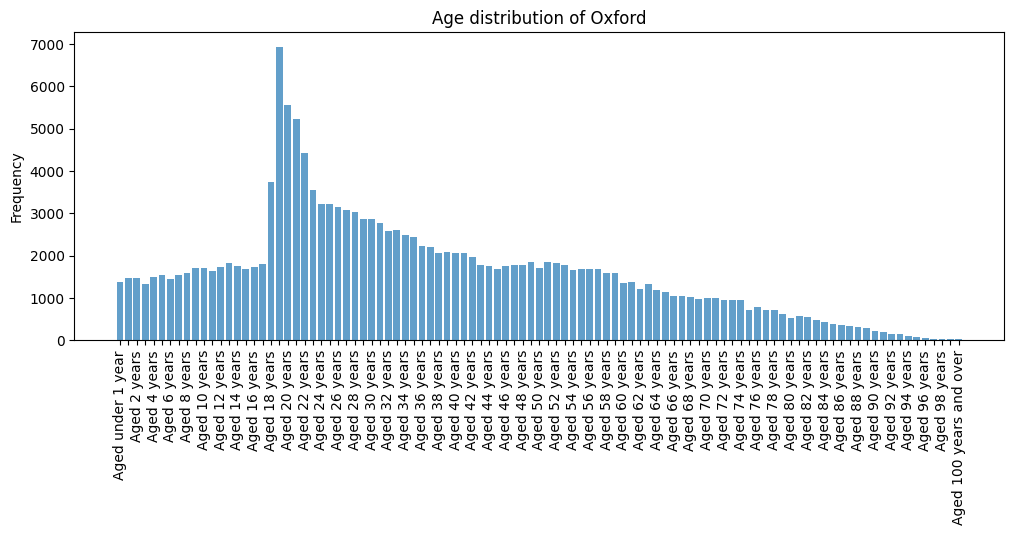

In [57]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(oxford['bins'].values, oxford['frequency'].values, alpha=0.7)
# Hiding every other x label to avoid crowding
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)
ax.tick_params(axis="x", labelrotation=90)
ax.set_ylabel("Frequency")
ax.set_title("Age distribution of Oxford");

To check for this, we can do the same as above for the other LAs and compare the Oxford result with them to see if it is an outlier.

In [38]:
medians = pd.DataFrame(columns=['local_authority', 'median_age'])
local_authorities = data['local_authority'].unique()

for local_authority in local_authorities:
    la_data = data[data['local_authority'] == local_authority].copy()
    
    la_dist = []
    for age, freq in zip(la_data["age"].values, la_data["frequency"].values):
        la_dist += [age] * freq
    
    la_median = np.median(la_dist)
    la_df = pd.DataFrame(
        {'local_authority': [local_authority], 
         'median_age': [la_median]}
        )
    
    medians = pd.concat([medians, la_df])
medians.head()

/var/folders/wb/5h7cs7g51ts3ndjm9x6xjjcr0000gn/T/ipykernel_99195/3007074311.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  medians = pd.concat([medians, la_df])


,local_authority,median_age
0,Hartlepool,42.0
0,Middlesbrough,37.0
0,Redcar and Cleveland,46.0
0,Stockton-on-Tees,41.0
0,Darlington,43.0


In [39]:
medians.describe()

,median_age
count,331.000000
mean,42.066465
std,4.893576
min,30.000000
25%,39.000000
50%,42.000000
75%,46.000000
max,54.000000


The average median for England and Wales as a whole is about 42, so it looks as though the student population in Oxford does have a significant impact on the median. If we plot the youngest ten local authorities, we see that Oxford in fact has the second youngest population by median, with other university towns (for example, Manchester, Nottingham and Cambridge) also present.  

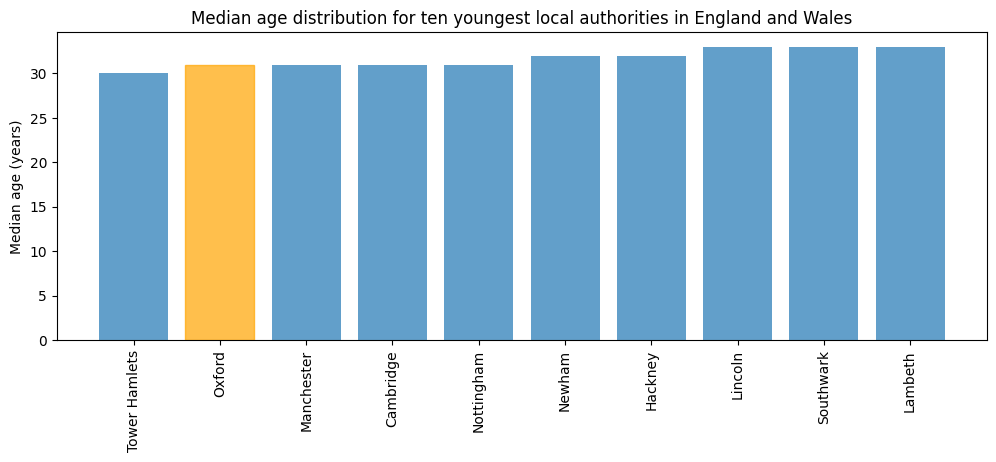

In [56]:
fig, ax = plt.subplots(figsize=(12,4))

plotting_data = medians.sort_values(by='median_age').copy().iloc[:10]
ax.bar(plotting_data["local_authority"].values, plotting_data["median_age"].values, alpha=0.7)
ax.tick_params(axis="x", labelrotation=90)
ax.set_ylabel("Median age (years)")
ax.set_title("Median ages for ten youngest local authorities in England and Wales")
ax.get_children()[1].set_color('orange');

To obtain a more comprehensive understanding of the median, we could calculate an adjusted median by
    
1. assuming that all students in Oxford are aged 18-24 and
2. subtracting the number of students from the appropriate bin frequencies before calculating the new median. 

One limitation is that some students may be outside the range 18-24, but the approach would still give us a good estimate of the median age of longer-term residents. A further simplification that could be made is that the number of students is evenly distributed across the 18-24 age band. This is unlikely to be true as students drop out before completing their studies, so there may be fewer 24-year-old students than 18-year-old students, but would suffice for a rough estimate.